<a href="https://colab.research.google.com/github/rohimatun/2025-Pengolahan-Citra-TI2B/blob/main/Jobsheet_4_Rohimatun_Nurin_Nadhifah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOBSHEET 4 : SEGMENTASI GAMBAR

Rohimatun Nurin Nadhifah / TI-2B / 4.33.23.1.22

## P1. Segmentasi Menggunakan Thresholding Global dan Otsu

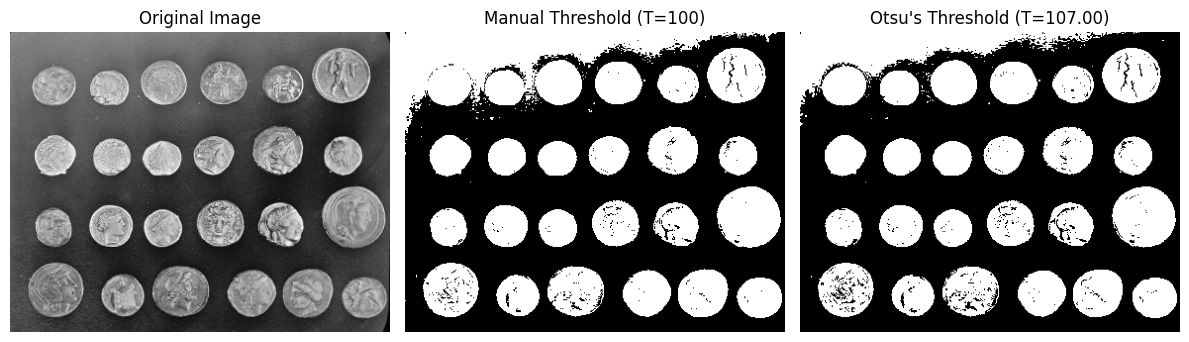

Nilai threshold Otsu yang ditemukan: 107.00


In [10]:
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_ubyte
from skimage.color import rgb2gray

# 1. Memuat citra (contoh: coins)
image_coins = data.coins()    # image sudah grayscale

# 2. Thresholding global (manual)
# Tentukan nilai ambang manual, misal 100
thresh_manual = 100
binary_manual = image_coins > thresh_manual

# 3. Thresholding otsu
thresh_otsu = filters.threshold_otsu(image_coins)
binary_otsu = image_coins > thresh_otsu

# 4. Visualisasi Hasil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_coins, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_manual, cmap=plt.cm.gray)
ax[1].set_title(f'Manual Threshold (T={thresh_manual})')
ax[1].axis('off')

ax[2].imshow(binary_otsu, cmap=plt.cm.gray)
ax[2].set_title(f'Otsu\'s Threshold (T={thresh_otsu:.2f})')
ax[2].axis('off')

plt.tight_layout()
plt.show()

# Menampilkan nilai threshold otsu
print(f"Nilai threshold Otsu yang ditemukan: {thresh_otsu:.2f}")

## P2. Segmentasi Menggunakan Region Growing (Contoh Sederhana)

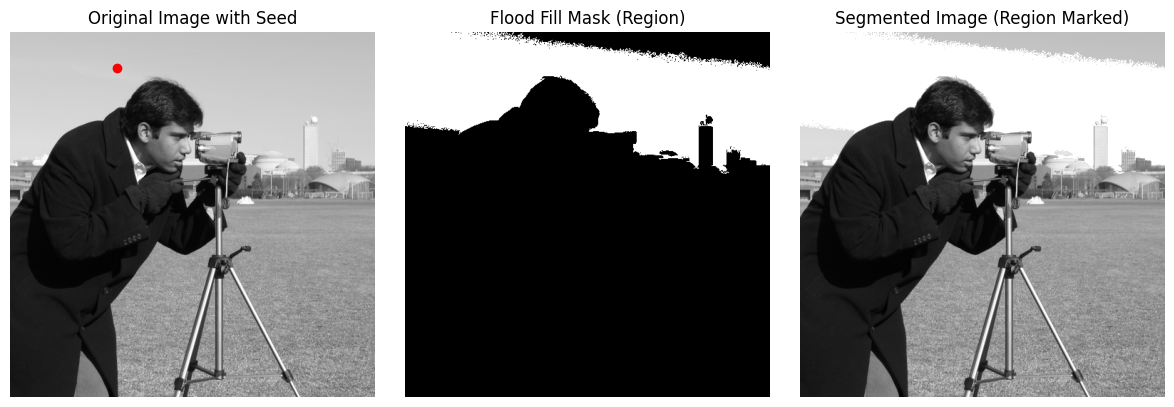

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, color

# 1. Memuat citra (contoh: camera)
image_camera = data.camera()

# 2. Tentukan titik 'seed' (benih)
# Misal, kita pilih titik di area langit (misal, koordinat  y=50, x=150)
seed_point =(50, 150)

# 3. Terapkan algoritma flood fill (mirip region growing)
# 'tolerance' menentukan seberapa besar perbedaan intensitas yang diizinkan
flood_mask = segmentation.flood(image_camera, seed_point, tolerance=10)

# 4. Buat citra tersegmentasi (tandai region yang 'tumbuh)
segmentation_image = np.copy(image_camera)
segmentation_image [flood_mask] = 255 # Tandai region dengan warna putih

# 5. Visualisasi hasil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_camera, cmap=plt.cm.gray)
ax[0].plot(seed_point[1], seed_point[0], 'ro')  # Tandai seed point
ax[0].set_title('Original Image with Seed')
ax[0].axis('off')

ax[1].imshow(flood_mask, cmap=plt.cm.gray)
ax[1].set_title('Flood Fill Mask (Region)')
ax[1].axis('off')

ax[2].imshow(segmentation_image, cmap=plt.cm.gray)
ax[2].set_title('Segmented Image (Region Marked)')
ax[2].axis('off')

plt.tight_layout()
plt.show()

## P3. Segmentasi Citra Berwarna Menggunakan K-Means Clustering

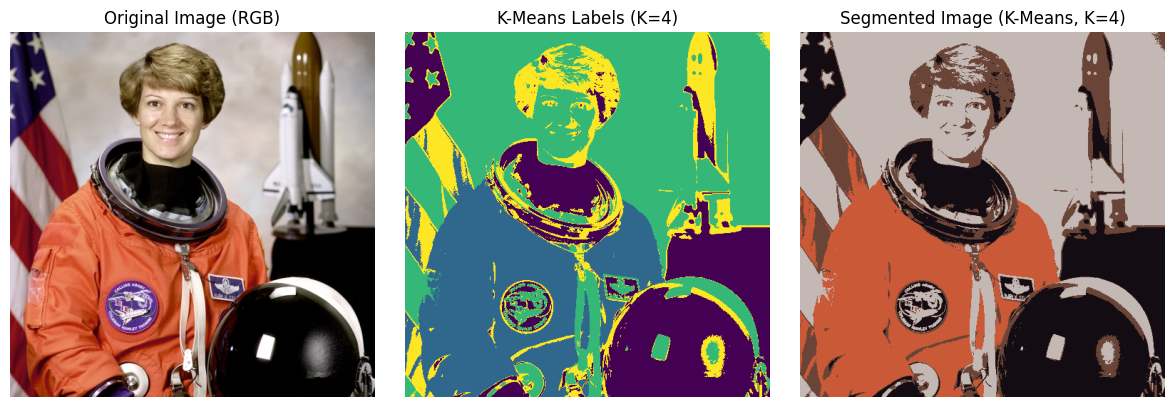

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb
import warnings

# 1. Memuat citra berwarna (contoh: astronaut)
image_astro = data.astronaut()
# Konversi ke float untuk perhitungan
image_astro_float = image_astro.astype(float) / 255.0

# 2. Reshape citra menjadi array piksel [jumlah_piksel, jumlah_fitur]
# Fitur bisa RGB atau Lab, ruang warna LAb seringkali lebih baik untuk persepsi warna
# Konversi ke Lab
image_lab = rgb2lab(image_astro_float)
rows, cols, dims = image_lab.shape
pixel_features = image_lab.reshape(rows * cols, dims)

# 3. Terapkan K-Means Clustering
# Tentukan jumlah klaster (segmen) yang diinginkan, misal K=4
n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init='auto')
# Hiding FeatureWarnings related to default value of n_init
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pixel_labels = kmeans.fit_predict(pixel_features)

# 4. Reshape label kembali ke bentuk citra
segmented_labels = pixel_labels.reshape(rows, cols)

# 5. Buat citra tersegmentasi (warnai setiap segemn dengan warna rata-rata klaster)
segmented_image_kmeans = np.zeros_like(image_lab)
centers_lab = kmeans.cluster_centers_
for k in range(n_cluster):
    # Dapatkan piksel yang termasuk klaster k
    cluster_pixels = (pixel_labels == k)
    # Isi piksel tersebut di citra baru dengan warna pusat klaster k
    # Perlu reshape kembali cluster_pixels ke bentuk citra
    mask_k = cluster_pixels.reshape(rows, cols)
    segmented_image_kmeans[mask_k] = centers_lab[k]

# Konversi kembali ke RGB untuk ditampilkan
segmented_image_rgb = lab2rgb(segmented_image_kmeans)

# 6. Visualisasi hsil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_astro)
ax[0].set_title('Original Image (RGB)')
ax[0].axis('off')

# Menampilkan label klaster
ax[1].imshow(segmented_labels, cmap='viridis')
ax[1].set_title(f'K-Means Labels (K={n_cluster})')
ax[1].axis('off')

# Menampilkan citra hasil segmentasi K-Means
ax[2].imshow(segmented_image_rgb)
ax[2].set_title(f'Segmented Image (K-Means, K={n_cluster})')
ax[2].axis('off')

plt.tight_layout()
plt.show()

## P4. Segmentasi Berbasis Tepi Menggunakan Watershed

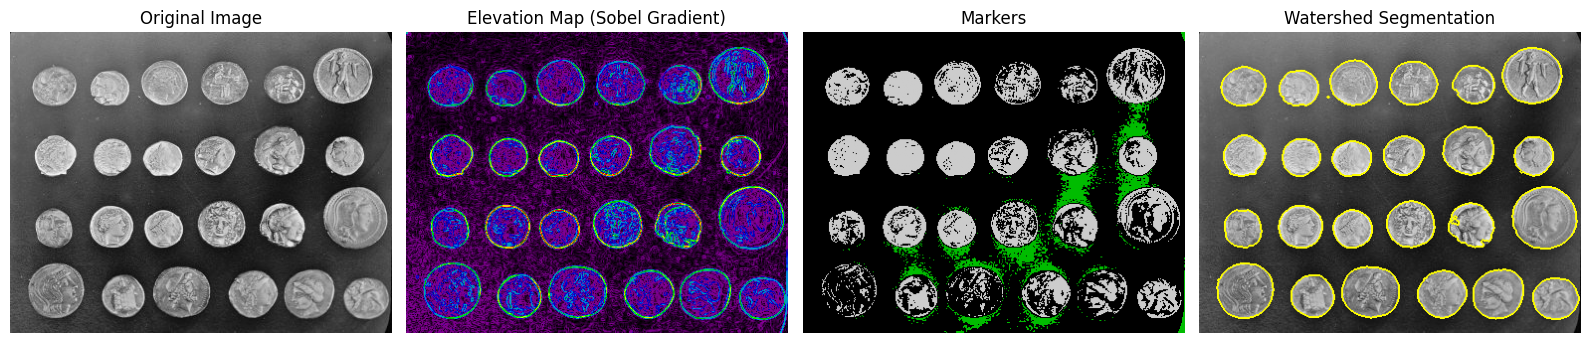

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, segmentation, morphology, measure
from scipy import ndimage as ndi

# 1. Memuat citra (contoh: coins)
image_coins = data.coins()

# 2. Hitung gradient citra (sebagai 'topografi')
elevation_map = filters.sobel(image_coins)

# 3. tentukan marker (penanda awal untuk setiap cekungan/objek)
# Kita bisa menggunakan thresholding untuk mendapatkan marker kasar
markers = np.zeros_like(image_coins)
markers[image_coins < 30] = 1   # Marker untuk latar belakang
markers[image_coins > 150] = 2  # Marker untuk objek (koin)

# Atau gunakan marker dari local maxima (lebih canggih)
# from skimage.feature import peak_local_max
# image_max = ndi.maximum_filter(image_coins, size=20, mode='constant')
# coordinates = peak_local_max(image_coins, min_distance=20)
# markers = np.zeros(image_coins.shape, dtype=bool)
# markers[tuple(coordinates.T)] = True
# markers = measure.label(markers)

# 4. Terapkan algoritma Watershed
segmentation_watershed = segmentation.watershed(elevation_map, markers)
# Warnai hasil segmentasi untuk visualisasi
segmented_colored = segmentation.mark_boundaries(image_coins, segmentation_watershed)

# 5. Visualisasi hasil
fig, axes = plt.subplots(ncols=4, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_coins, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(elevation_map, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Elevation Map (Sobel Gradient)')
ax[1].axis('off')

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Markers')
ax[2].axis('off')

ax[3].imshow(segmented_colored)
ax[3].set_title('Watershed Segmentation')
ax[3].axis('off')

plt.tight_layout()
plt.show()

## P5. Perbandingan Visualisasi Hasil Segmentasi

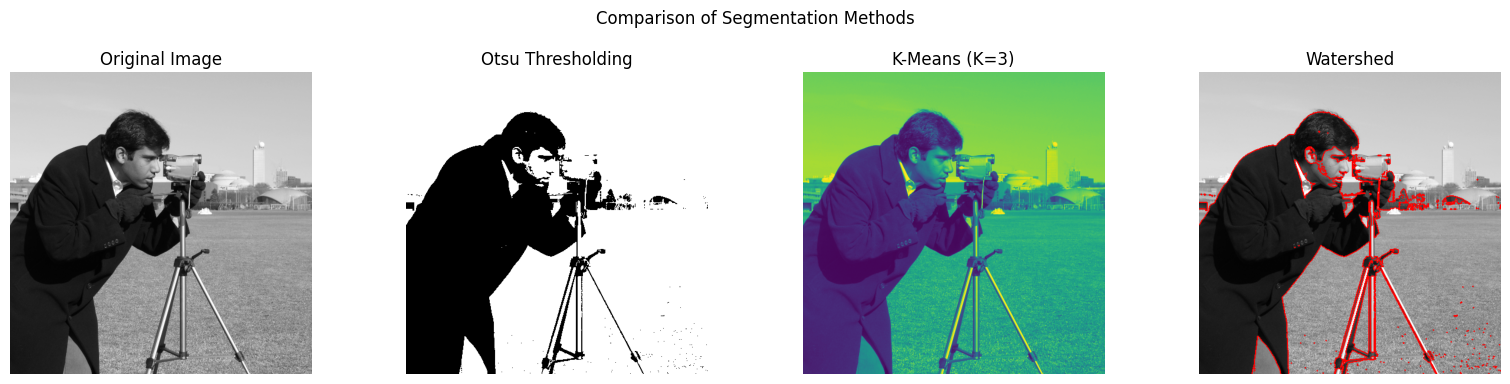

In [9]:
import matplotlib.pyplot as plt
from skimage import data, filters, segmentation, img_as_float, color
from sklearn.cluster import KMeans
import numpy as np
import warnings

# 1. Pilih satu citra untuk perbandingan (misal: camera)
image = data.camera()
image_float = img_as_float(image)

# 2. Lakukam beberapa metode segmentasi
# a) Otsu Thresholding
thresh_otsu = filters.threshold_otsu(image)
binary_ostu = image > thresh_otsu

# b) K-Means (misal K=3)
# Reshape untuk KMeans (1 fitur : intensitas)
rows, cols = image.shape
pixel_features = image_float.reshape(rows * cols, 1)
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init='auto')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pixel_labels = kmeans.fit_predict(pixel_features)
segmented_kmeans_labels = pixel_features.reshape(rows, cols)

# c) Watershed (gunakan marker sederhana dari Otsu)
elevation_map = filters.sobel(image)
markers = np.zeros_like(image)
markers[image < thresh_otsu] = 1
markers[image > thresh_otsu] = 2
segmentation_watershed = segmentation.watershed(elevation_map, markers)

# 3. Visualisasi Perbandingan
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_ostu, cmap=plt.cm.gray)
ax[1].set_title('Otsu Thresholding')
ax[1].axis('off')

ax[2].imshow(segmented_kmeans_labels, cmap='viridis')   # Gunakan cmap berbeda untuk label
ax[2].set_title(f'K-Means (K={n_cluster})')
ax[2].axis('off')

# Gunakan mark_boundaries untuk Watershed agar lebih jelas
segmented_watersher_colored = segmentation.mark_boundaries(image_float, segmentation_watershed, color=(1,0,0))  # Batas merah
ax[3].imshow(segmented_watersher_colored)
ax[3].set_title('Watershed')
ax[3].axis('off')

plt.suptitle('Comparison of Segmentation Methods')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])   # Adjust layout to make space for suptitle
plt.show()

## Tugas 1

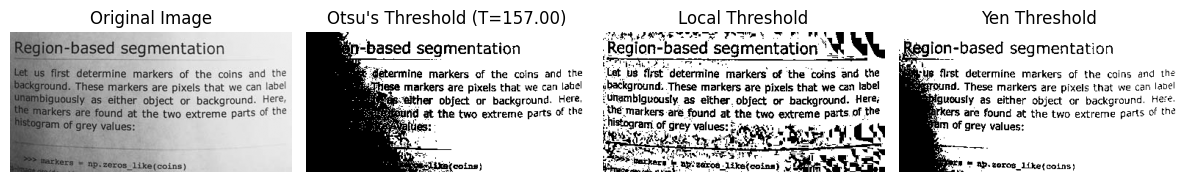

Nilai threshold Otsu yang ditemukan: 157.00


In [15]:
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_ubyte
from skimage.color import rgb2gray

# 1. Memuat citra
image_page = data.page()

# 2. Thresholding otsu
thresh_otsu = filters.threshold_otsu(image_page)
binary_otsu = image_page > thresh_otsu

# 3. Thresholding local
thresh_local = filters.threshold_local(image_page, block_size=35)
binary_local = image_page > thresh_local

# 4. Thresholding yen
thresh_yen = filters.threshold_yen(image_page)
binary_yen = image_page > thresh_yen

# 5. Visualisasi Hasil
fig, axes = plt.subplots(ncols=4, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_page, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_otsu, cmap=plt.cm.gray)
ax[1].set_title(f'Otsu\'s Threshold (T={thresh_otsu:.2f})')
ax[1].axis('off')

ax[2].imshow(binary_local, cmap=plt.cm.gray)
ax[2].set_title('Local Threshold')
ax[2].axis('off')

ax[3].imshow(binary_yen, cmap=plt.cm.gray)
ax[3].set_title('Yen Threshold')
ax[3].axis('off')

plt.tight_layout()
plt.show()

# Menampilkan nilai threshold otsu
print(f"Nilai threshold Otsu yang ditemukan: {thresh_otsu:.2f}")

## Tugas 2

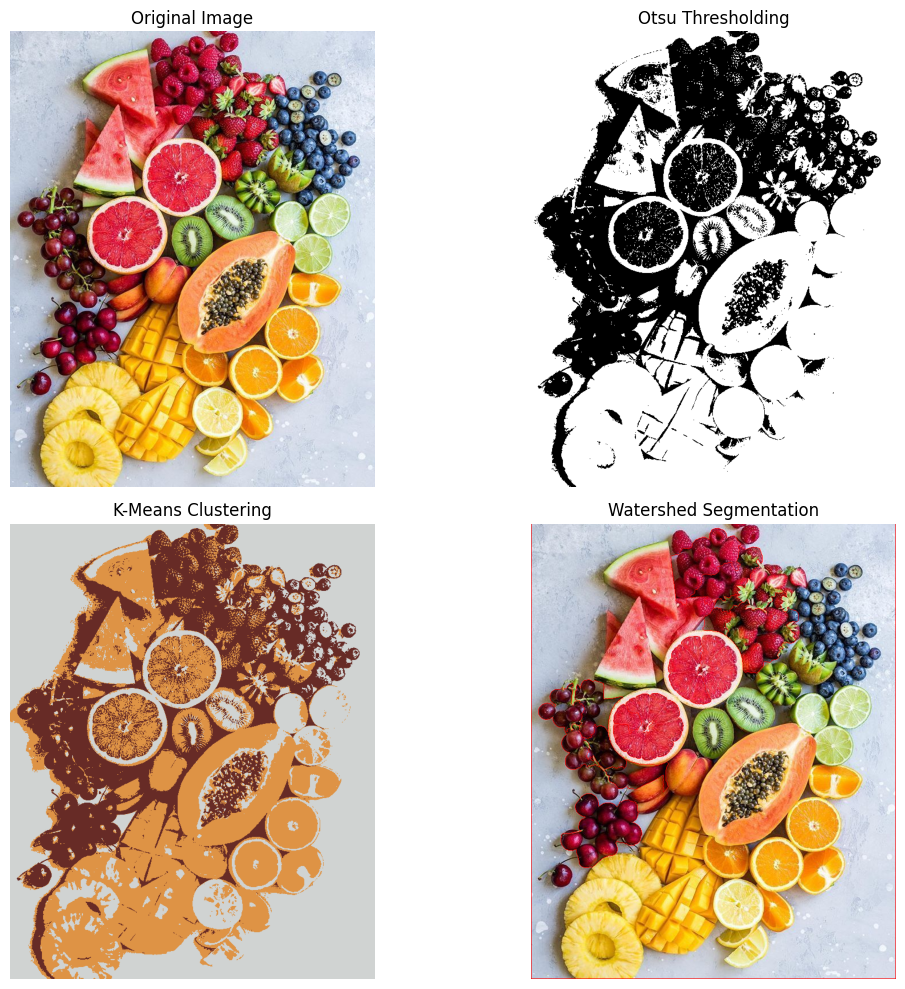

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage.segmentation import watershed
from scipy import ndimage as ndi

# --- Load gambar buah ---
image_path = 'buah.jpeg'  # path file upload kamu
image_buah = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_buah, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_buah, cv2.COLOR_BGR2GRAY)

# --- 1. Segmentasi dengan Otsu Threshold ---
thresh_otsu = filters.threshold_otsu(gray)
binary_otsu = gray > thresh_otsu

# --- 2. Segmentasi dengan K-Means Clustering ---
pixel_values = image_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3  # jumlah cluster
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_rgb.shape)

# --- 3. Segmentasi dengan Watershed ---
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed
markers = cv2.watershed(image_buah, markers)
watershed_image = image_rgb.copy()
watershed_image[markers == -1] = [255, 0, 0]  # Mark boundary in red

# --- Plot hasil ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(binary_otsu, cmap='gray')
axes[1].set_title('Otsu Thresholding')
axes[1].axis('off')

axes[2].imshow(segmented_image)
axes[2].set_title('K-Means Clustering')
axes[2].axis('off')

axes[3].imshow(watershed_image)
axes[3].set_title('Watershed Segmentation')
axes[3].axis('off')

plt.tight_layout()
plt.show()
